In [196]:
import os
import csv

#os.chdir(r'C:\My\x2\180617\_merge')
mypath = os.getcwd()
print(mypath)

C:\My\Playground\Github\pg\_chaos


In [197]:
infile_name = '20180617.csv'
infile_name = '180617_19-50-00.327.csv'

In [198]:
with open(infile_name, encoding='utf8') as csvf:
    rd = csv.reader(csvf, delimiter=',')
    for idx, line in enumerate(rd):
        print(line)
        
        if idx > 10:
            break

['0', '2018-06-17 195000.327002', '0.060999', '2.448898', '2.550633', '2.465567', '100', '1']
['1', '2018-06-17 195000.327004', '0.060352', '2.448898', '2.549986', '2.46589', '100', '1']
['2', '2018-06-17 195000.327006', '0.059705', '2.448898', '2.549016', '2.46589', '100', '1']
['3', '2018-06-17 195000.327008', '0.059058', '2.448898', '2.547723', '2.466536', '100', '1']
['4', '2018-06-17 195000.327010', '0.058411', '2.449222', '2.548369', '2.467829', '100', '1']
['5', '2018-06-17 195000.327012', '0.057441', '2.449222', '2.548046', '2.468152', '100', '1']
['6', '2018-06-17 195000.327014', '0.057441', '2.449545', '2.547723', '2.468798', '100', '1']
['7', '2018-06-17 195000.327016', '0.056793', '2.449545', '2.547723', '2.469122', '100', '1']
['8', '2018-06-17 195000.327018', '0.056146', '2.450839', '2.547399', '2.469445', '100', '1']
['9', '2018-06-17 195000.327020', '0.055823', '2.45181', '2.547399', '2.469768', '100', '1']
['10', '2018-06-17 195000.327022', '0.054852', '2.452781', '2.5

In [199]:
import pandas as pd
import numpy as np

names = ['idx', 'reg_date', 'gold', 'silver_u', 'silver_v', 'silver_w', 'hz', 'ch']
df = pd.read_csv(infile_name, sep=',', names=names)
# df = df.sample(frac=1)

In [206]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

max_row = 70000

data_X = df[['silver_u', 'silver_w', 'silver_v']] .values.reshape(-1,3)[0:max_row, :]
data_y = df[['gold']][0:max_row] / 5 * 1000

poly = PolynomialFeatures(degree=5)
X_poly_reg = poly.fit_transform(data_X)

model_poly_reg = LinearRegression()
model_poly_reg.fit(X_poly_reg, data_y)
pred_poly_reg = model_poly_reg.predict(X_poly_reg)

In [ ]:
data_y

In [207]:
X_poly_reg.shape

(25000, 56)

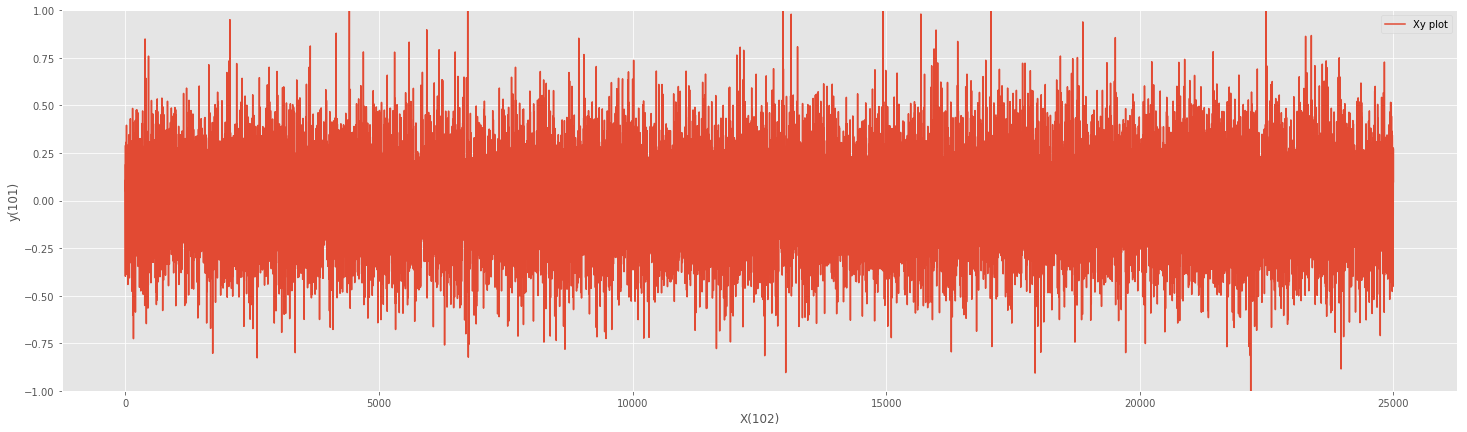

In [208]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=1, ymin=-1)
plt_x = range(len(data_X[:, 0]))
plt.plot(plt_x, (data_y - pred_poly_reg), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()

In [186]:
import tensorflow as tf
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler


def reset_graph(seed=1):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [209]:
reset_graph()

scaler = MinMaxScaler(feature_range=(-1 + 1e-5, 1 - 1e-5))
scaler.fit(data_X)
data_X_arcsin = np.arcsin(scaler.transform(data_X))
data_X_sin = np.sin(scaler.transform(data_X))
data_X_arccos = np.arccos(scaler.transform(data_X))
data_X_cos = np.cos(scaler.transform(data_X))
training_X = np.concatenate((data_X_sin, data_X_arcsin, data_X_arccos), axis=1)
np.random.shuffle(training_X)
training_y = data_y
test_X = None
test_y = None

learning_rate = 0.01
n_input = training_X.shape[1]
n_hidden = 20
n_epochs = 10000
now = datetime.now().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"


he_init = tf.contrib.layers.variance_scaling_initializer()  
    
with tf.name_scope('y') as scope:
    y = tf.placeholder(dtype=tf.int64, shape=[None, 1], name='y')

with tf.name_scope('dnn'):
    input_layer = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name='X')
    hidden = tf.layers.dense(inputs=input_layer,      units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')
    hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden2')
    hidden = tf.layers.dense(inputs=hidden, units=n_hidden, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden3')
    output_layer = tf.layers.dense(inputs=hidden, units=1)
    
with tf.name_scope('loss'):
    loss = tf.losses.mean_squared_error(y, output_layer)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    
saver = tf.train.Saver()
save_path = '{}/run-{}/'.format(root_logdir, now, now) + 'model-session.ckpt'

In [210]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        _, loss_val = sess.run([train_op, loss], feed_dict={input_layer: training_X, y:training_y})
        print('Epoch[{}]:'.format(epoch), loss_val)
    
    _save_path = saver.save(sess, save_path)

Epoch[0]: 4418.514
Epoch[1]: 4417.8066
Epoch[2]: 4418.033
Epoch[3]: 4417.7896
Epoch[4]: 4417.5435
Epoch[5]: 4417.5063
Epoch[6]: 4417.5435
Epoch[7]: 4417.513
Epoch[8]: 4417.3896
Epoch[9]: 4417.263
Epoch[10]: 4417.2085
Epoch[11]: 4417.194
Epoch[12]: 4417.158
Epoch[13]: 4417.0903
Epoch[14]: 4417.008
Epoch[15]: 4416.9297
Epoch[16]: 4416.8813
Epoch[17]: 4416.851
Epoch[18]: 4416.8027
Epoch[19]: 4416.7134
Epoch[20]: 4416.6494
Epoch[21]: 4416.6133
Epoch[22]: 4416.573
Epoch[23]: 4416.511
Epoch[24]: 4416.4614
Epoch[25]: 4416.433
Epoch[26]: 4416.395
Epoch[27]: 4416.3345
Epoch[28]: 4416.29
Epoch[29]: 4416.2656
Epoch[30]: 4416.231
Epoch[31]: 4416.188
Epoch[32]: 4416.1606
Epoch[33]: 4416.136
Epoch[34]: 4416.104
Epoch[35]: 4416.0728
Epoch[36]: 4416.051
Epoch[37]: 4416.015
Epoch[38]: 4415.9897
Epoch[39]: 4415.961
Epoch[40]: 4415.945
Epoch[41]: 4415.924
Epoch[42]: 4415.9077
Epoch[43]: 4415.8906
Epoch[44]: 4415.869
Epoch[45]: 4415.8516
Epoch[46]: 4415.835
Epoch[47]: 4415.8145
Epoch[48]: 4415.7915
Epoch[

Epoch[388]: 4412.5547
Epoch[389]: 4412.8564
Epoch[390]: 4412.7104
Epoch[391]: 4412.4336
Epoch[392]: 4411.929
Epoch[393]: 4411.919
Epoch[394]: 4412.033
Epoch[395]: 4412.29
Epoch[396]: 4412.247
Epoch[397]: 4411.9795
Epoch[398]: 4411.8496
Epoch[399]: 4411.8447
Epoch[400]: 4412.0254
Epoch[401]: 4412.055
Epoch[402]: 4411.9004
Epoch[403]: 4411.808
Epoch[404]: 4411.853
Epoch[405]: 4411.938
Epoch[406]: 4411.8843
Epoch[407]: 4411.797
Epoch[408]: 4411.7246
Epoch[409]: 4411.8228
Epoch[410]: 4411.84
Epoch[411]: 4411.841
Epoch[412]: 4411.7583
Epoch[413]: 4411.7
Epoch[414]: 4411.7134
Epoch[415]: 4411.7646
Epoch[416]: 4411.7896
Epoch[417]: 4411.786
Epoch[418]: 4411.756
Epoch[419]: 4411.694
Epoch[420]: 4411.6626
Epoch[421]: 4411.6465
Epoch[422]: 4411.6543
Epoch[423]: 4411.6357
Epoch[424]: 4411.63
Epoch[425]: 4411.647
Epoch[426]: 4411.6543
Epoch[427]: 4411.6597
Epoch[428]: 4411.6807
Epoch[429]: 4411.667
Epoch[430]: 4411.6978
Epoch[431]: 4411.709
Epoch[432]: 4411.7837
Epoch[433]: 4411.846
Epoch[434]: 44

Epoch[772]: 4410.894
Epoch[773]: 4411.6357
Epoch[774]: 4411.306
Epoch[775]: 4410.047
Epoch[776]: 4411.1377
Epoch[777]: 4411.6826
Epoch[778]: 4410.534
Epoch[779]: 4410.467
Epoch[780]: 4411.2334
Epoch[781]: 4410.5903
Epoch[782]: 4410.504
Epoch[783]: 4410.8276
Epoch[784]: 4410.943
Epoch[785]: 4410.5825
Epoch[786]: 4410.191
Epoch[787]: 4410.4604
Epoch[788]: 4410.3647
Epoch[789]: 4410.2905
Epoch[790]: 4410.317
Epoch[791]: 4409.9775
Epoch[792]: 4410.128
Epoch[793]: 4410.3506
Epoch[794]: 4410.012
Epoch[795]: 4410.119
Epoch[796]: 4410.1313
Epoch[797]: 4409.8438
Epoch[798]: 4410.099
Epoch[799]: 4409.953
Epoch[800]: 4409.7397
Epoch[801]: 4409.8267
Epoch[802]: 4409.7993
Epoch[803]: 4409.961
Epoch[804]: 4409.846
Epoch[805]: 4409.735
Epoch[806]: 4409.744
Epoch[807]: 4409.736
Epoch[808]: 4409.8027
Epoch[809]: 4409.7197
Epoch[810]: 4409.73
Epoch[811]: 4409.666
Epoch[812]: 4409.637
Epoch[813]: 4409.7134
Epoch[814]: 4409.6772
Epoch[815]: 4409.708
Epoch[816]: 4409.665
Epoch[817]: 4409.643
Epoch[818]: 44

Epoch[1150]: 4408.8315
Epoch[1151]: 4408.592
Epoch[1152]: 4408.447
Epoch[1153]: 4408.2324
Epoch[1154]: 4408.184
Epoch[1155]: 4408.2305
Epoch[1156]: 4408.509
Epoch[1157]: 4408.713
Epoch[1158]: 4409.001
Epoch[1159]: 4408.948
Epoch[1160]: 4408.82
Epoch[1161]: 4408.449
Epoch[1162]: 4408.316
Epoch[1163]: 4408.134
Epoch[1164]: 4408.2417
Epoch[1165]: 4408.3223
Epoch[1166]: 4408.4116
Epoch[1167]: 4408.492
Epoch[1168]: 4408.475
Epoch[1169]: 4408.474
Epoch[1170]: 4408.3193
Epoch[1171]: 4408.2314
Epoch[1172]: 4408.0796
Epoch[1173]: 4408.1694
Epoch[1174]: 4408.2
Epoch[1175]: 4408.348
Epoch[1176]: 4408.498
Epoch[1177]: 4408.803
Epoch[1178]: 4408.9766
Epoch[1179]: 4409.117
Epoch[1180]: 4408.9824
Epoch[1181]: 4409.016
Epoch[1182]: 4408.539
Epoch[1183]: 4408.359
Epoch[1184]: 4408.1294
Epoch[1185]: 4408.098
Epoch[1186]: 4408.095
Epoch[1187]: 4408.281
Epoch[1188]: 4408.3
Epoch[1189]: 4408.4224
Epoch[1190]: 4408.3784
Epoch[1191]: 4408.484
Epoch[1192]: 4408.618
Epoch[1193]: 4408.646
Epoch[1194]: 4408.78
E

Epoch[1522]: 4407.056
Epoch[1523]: 4407.044
Epoch[1524]: 4407.057
Epoch[1525]: 4407.0747
Epoch[1526]: 4407.05
Epoch[1527]: 4407.08
Epoch[1528]: 4407.113
Epoch[1529]: 4407.116
Epoch[1530]: 4407.2476
Epoch[1531]: 4407.234
Epoch[1532]: 4407.4434
Epoch[1533]: 4407.6777
Epoch[1534]: 4407.969
Epoch[1535]: 4408.619
Epoch[1536]: 4409.4253
Epoch[1537]: 4410.23
Epoch[1538]: 4410.445
Epoch[1539]: 4409.5605
Epoch[1540]: 4408.215
Epoch[1541]: 4407.2217
Epoch[1542]: 4407.396
Epoch[1543]: 4408.47
Epoch[1544]: 4408.8555
Epoch[1545]: 4408.4785
Epoch[1546]: 4407.775
Epoch[1547]: 4407.1694
Epoch[1548]: 4407.2754
Epoch[1549]: 4408.006
Epoch[1550]: 4408.2197
Epoch[1551]: 4408.2593
Epoch[1552]: 4407.786
Epoch[1553]: 4407.4014
Epoch[1554]: 4407.1016
Epoch[1555]: 4407.2007
Epoch[1556]: 4407.532
Epoch[1557]: 4407.742
Epoch[1558]: 4407.668
Epoch[1559]: 4407.329
Epoch[1560]: 4407.1514
Epoch[1561]: 4407.214
Epoch[1562]: 4407.238
Epoch[1563]: 4407.5967
Epoch[1564]: 4407.6235
Epoch[1565]: 4407.458
Epoch[1566]: 4407

Epoch[1890]: 4406.679
Epoch[1891]: 4406.9844
Epoch[1892]: 4407.2173
Epoch[1893]: 4407.6055
Epoch[1894]: 4408.099
Epoch[1895]: 4408.43
Epoch[1896]: 4408.634
Epoch[1897]: 4408.2583
Epoch[1898]: 4407.6567
Epoch[1899]: 4406.882
Epoch[1900]: 4406.297
Epoch[1901]: 4406.218
Epoch[1902]: 4406.3433
Epoch[1903]: 4406.82
Epoch[1904]: 4407.022
Epoch[1905]: 4407.377
Epoch[1906]: 4407.293
Epoch[1907]: 4407.0356
Epoch[1908]: 4406.6245
Epoch[1909]: 4406.3906
Epoch[1910]: 4406.1426
Epoch[1911]: 4406.2324
Epoch[1912]: 4406.3687
Epoch[1913]: 4406.6797
Epoch[1914]: 4406.9233
Epoch[1915]: 4406.8315
Epoch[1916]: 4406.662
Epoch[1917]: 4406.3657
Epoch[1918]: 4406.2617
Epoch[1919]: 4406.1147
Epoch[1920]: 4406.216
Epoch[1921]: 4406.276
Epoch[1922]: 4406.6465
Epoch[1923]: 4406.5786
Epoch[1924]: 4406.738
Epoch[1925]: 4406.4375
Epoch[1926]: 4406.436
Epoch[1927]: 4406.2163
Epoch[1928]: 4406.1255
Epoch[1929]: 4406.0405
Epoch[1930]: 4406.0776
Epoch[1931]: 4406.135
Epoch[1932]: 4406.1826
Epoch[1933]: 4406.182
Epoch[19

Epoch[2256]: 4406.1465
Epoch[2257]: 4406.16
Epoch[2258]: 4406.504
Epoch[2259]: 4406.645
Epoch[2260]: 4406.7583
Epoch[2261]: 4406.502
Epoch[2262]: 4406.2983
Epoch[2263]: 4405.989
Epoch[2264]: 4405.731
Epoch[2265]: 4405.4507
Epoch[2266]: 4405.229
Epoch[2267]: 4405.102
Epoch[2268]: 4405.001
Epoch[2269]: 4404.948
Epoch[2270]: 4404.99
Epoch[2271]: 4405.035
Epoch[2272]: 4405.15
Epoch[2273]: 4405.1445
Epoch[2274]: 4405.3135
Epoch[2275]: 4405.681
Epoch[2276]: 4406.0254
Epoch[2277]: 4406.4883
Epoch[2278]: 4406.556
Epoch[2279]: 4406.681
Epoch[2280]: 4406.432
Epoch[2281]: 4406.1323
Epoch[2282]: 4405.7217
Epoch[2283]: 4405.4673
Epoch[2284]: 4405.127
Epoch[2285]: 4404.9873
Epoch[2286]: 4404.933
Epoch[2287]: 4404.914
Epoch[2288]: 4404.9736
Epoch[2289]: 4404.9985
Epoch[2290]: 4405.2593
Epoch[2291]: 4405.327
Epoch[2292]: 4405.63
Epoch[2293]: 4405.689
Epoch[2294]: 4405.9326
Epoch[2295]: 4405.9736
Epoch[2296]: 4405.9595
Epoch[2297]: 4405.7656
Epoch[2298]: 4405.6553
Epoch[2299]: 4405.395
Epoch[2300]: 440

Epoch[2629]: 4404.222
Epoch[2630]: 4404.155
Epoch[2631]: 4404.2856
Epoch[2632]: 4404.3564
Epoch[2633]: 4404.5195
Epoch[2634]: 4404.919
Epoch[2635]: 4405.4053
Epoch[2636]: 4406.3457
Epoch[2637]: 4407.359
Epoch[2638]: 4408.839
Epoch[2639]: 4409.5747
Epoch[2640]: 4409.6895
Epoch[2641]: 4407.9717
Epoch[2642]: 4405.8525
Epoch[2643]: 4404.6265
Epoch[2644]: 4404.2856
Epoch[2645]: 4405.5503
Epoch[2646]: 4406.5293
Epoch[2647]: 4406.93
Epoch[2648]: 4405.9443
Epoch[2649]: 4404.8506
Epoch[2650]: 4404.1514
Epoch[2651]: 4404.4595
Epoch[2652]: 4405.0444
Epoch[2653]: 4405.432
Epoch[2654]: 4405.2793
Epoch[2655]: 4404.7393
Epoch[2656]: 4404.1953
Epoch[2657]: 4404.146
Epoch[2658]: 4404.2754
Epoch[2659]: 4404.5547
Epoch[2660]: 4404.7866
Epoch[2661]: 4404.8545
Epoch[2662]: 4404.666
Epoch[2663]: 4404.428
Epoch[2664]: 4404.176
Epoch[2665]: 4404.0654
Epoch[2666]: 4404.0703
Epoch[2667]: 4404.1587
Epoch[2668]: 4404.2725
Epoch[2669]: 4404.38
Epoch[2670]: 4404.4785
Epoch[2671]: 4404.438
Epoch[2672]: 4404.3535
Epo

Epoch[2997]: 4403.74
Epoch[2998]: 4403.602
Epoch[2999]: 4403.801
Epoch[3000]: 4403.777
Epoch[3001]: 4403.807
Epoch[3002]: 4403.732
Epoch[3003]: 4403.672
Epoch[3004]: 4403.798
Epoch[3005]: 4403.8594
Epoch[3006]: 4403.8257
Epoch[3007]: 4403.8335
Epoch[3008]: 4403.88
Epoch[3009]: 4404.2446
Epoch[3010]: 4404.198
Epoch[3011]: 4404.462
Epoch[3012]: 4404.483
Epoch[3013]: 4405.095
Epoch[3014]: 4405.2207
Epoch[3015]: 4405.5166
Epoch[3016]: 4405.7285
Epoch[3017]: 4406.2866
Epoch[3018]: 4406.2563
Epoch[3019]: 4406.278
Epoch[3020]: 4405.57
Epoch[3021]: 4405.013
Epoch[3022]: 4404.348
Epoch[3023]: 4404.033
Epoch[3024]: 4403.834
Epoch[3025]: 4404.055
Epoch[3026]: 4404.164
Epoch[3027]: 4404.774
Epoch[3028]: 4404.853
Epoch[3029]: 4405.0664
Epoch[3030]: 4404.638
Epoch[3031]: 4404.4927
Epoch[3032]: 4404.294
Epoch[3033]: 4403.95
Epoch[3034]: 4403.7285
Epoch[3035]: 4403.813
Epoch[3036]: 4403.988
Epoch[3037]: 4403.9727
Epoch[3038]: 4404.368
Epoch[3039]: 4404.5103
Epoch[3040]: 4404.899
Epoch[3041]: 4404.388


Epoch[3364]: 4403.506
Epoch[3365]: 4403.7896
Epoch[3366]: 4403.7407
Epoch[3367]: 4404.0366
Epoch[3368]: 4403.915
Epoch[3369]: 4404.1562
Epoch[3370]: 4403.9033
Epoch[3371]: 4404.044
Epoch[3372]: 4403.746
Epoch[3373]: 4403.842
Epoch[3374]: 4403.4546
Epoch[3375]: 4403.725
Epoch[3376]: 4403.4004
Epoch[3377]: 4403.5444
Epoch[3378]: 4403.2915
Epoch[3379]: 4403.5215
Epoch[3380]: 4403.5205
Epoch[3381]: 4403.8267
Epoch[3382]: 4404.4316
Epoch[3383]: 4404.768
Epoch[3384]: 4405.4116
Epoch[3385]: 4405.6045
Epoch[3386]: 4405.843
Epoch[3387]: 4405.8286
Epoch[3388]: 4404.9746
Epoch[3389]: 4404.3975
Epoch[3390]: 4403.5884
Epoch[3391]: 4403.48
Epoch[3392]: 4403.2983
Epoch[3393]: 4403.864
Epoch[3394]: 4404.188
Epoch[3395]: 4404.2764
Epoch[3396]: 4404.3794
Epoch[3397]: 4404.2373
Epoch[3398]: 4403.836
Epoch[3399]: 4403.816
Epoch[3400]: 4403.361
Epoch[3401]: 4403.322
Epoch[3402]: 4403.3013
Epoch[3403]: 4403.369
Epoch[3404]: 4403.3623
Epoch[3405]: 4403.5234
Epoch[3406]: 4403.6943
Epoch[3407]: 4403.824
Epoch[

Epoch[3730]: 4403.7275
Epoch[3731]: 4403.5605
Epoch[3732]: 4403.442
Epoch[3733]: 4403.202
Epoch[3734]: 4403.0317
Epoch[3735]: 4402.991
Epoch[3736]: 4402.964
Epoch[3737]: 4403.102
Epoch[3738]: 4402.965
Epoch[3739]: 4403.137
Epoch[3740]: 4403.2407
Epoch[3741]: 4403.5967
Epoch[3742]: 4403.653
Epoch[3743]: 4403.92
Epoch[3744]: 4404.531
Epoch[3745]: 4404.503
Epoch[3746]: 4404.8267
Epoch[3747]: 4404.672
Epoch[3748]: 4404.4546
Epoch[3749]: 4403.9565
Epoch[3750]: 4403.493
Epoch[3751]: 4403.1387
Epoch[3752]: 4402.9316
Epoch[3753]: 4402.9478
Epoch[3754]: 4403.017
Epoch[3755]: 4403.464
Epoch[3756]: 4403.8315
Epoch[3757]: 4404.481
Epoch[3758]: 4404.848
Epoch[3759]: 4404.7456
Epoch[3760]: 4404.9204
Epoch[3761]: 4404.3135
Epoch[3762]: 4403.8833
Epoch[3763]: 4403.2603
Epoch[3764]: 4402.919
Epoch[3765]: 4402.9243
Epoch[3766]: 4403.0566
Epoch[3767]: 4403.4155
Epoch[3768]: 4403.592
Epoch[3769]: 4403.8145
Epoch[3770]: 4403.836
Epoch[3771]: 4403.9272
Epoch[3772]: 4403.7686
Epoch[3773]: 4403.4473
Epoch[377

Epoch[4101]: 4402.556
Epoch[4102]: 4402.528
Epoch[4103]: 4402.5234
Epoch[4104]: 4402.5273
Epoch[4105]: 4402.6
Epoch[4106]: 4402.715
Epoch[4107]: 4402.906
Epoch[4108]: 4403.218
Epoch[4109]: 4403.7085
Epoch[4110]: 4404.229
Epoch[4111]: 4404.9287
Epoch[4112]: 4405.289
Epoch[4113]: 4405.5376
Epoch[4114]: 4405.01
Epoch[4115]: 4404.153
Epoch[4116]: 4403.458
Epoch[4117]: 4402.7515
Epoch[4118]: 4402.8755
Epoch[4119]: 4402.939
Epoch[4120]: 4403.3696
Epoch[4121]: 4403.7754
Epoch[4122]: 4403.998
Epoch[4123]: 4404.0933
Epoch[4124]: 4403.606
Epoch[4125]: 4403.2197
Epoch[4126]: 4402.7524
Epoch[4127]: 4402.607
Epoch[4128]: 4402.631
Epoch[4129]: 4402.8047
Epoch[4130]: 4403.2754
Epoch[4131]: 4403.6265
Epoch[4132]: 4404.0293
Epoch[4133]: 4404.0127
Epoch[4134]: 4403.878
Epoch[4135]: 4403.486
Epoch[4136]: 4403.0596
Epoch[4137]: 4402.962
Epoch[4138]: 4402.6123
Epoch[4139]: 4402.6357
Epoch[4140]: 4402.7573
Epoch[4141]: 4403.1387
Epoch[4142]: 4403.402
Epoch[4143]: 4403.4033
Epoch[4144]: 4403.3867
Epoch[4145]

Epoch[4469]: 4404.1797
Epoch[4470]: 4404.185
Epoch[4471]: 4403.6255
Epoch[4472]: 4402.9243
Epoch[4473]: 4402.36
Epoch[4474]: 4402.182
Epoch[4475]: 4402.459
Epoch[4476]: 4402.9834
Epoch[4477]: 4403.582
Epoch[4478]: 4403.956
Epoch[4479]: 4404.0244
Epoch[4480]: 4403.5547
Epoch[4481]: 4403.046
Epoch[4482]: 4402.4834
Epoch[4483]: 4402.2163
Epoch[4484]: 4402.202
Epoch[4485]: 4402.3975
Epoch[4486]: 4402.6895
Epoch[4487]: 4402.8174
Epoch[4488]: 4402.8594
Epoch[4489]: 4402.7124
Epoch[4490]: 4402.4766
Epoch[4491]: 4402.333
Epoch[4492]: 4402.1953
Epoch[4493]: 4402.1943
Epoch[4494]: 4402.295
Epoch[4495]: 4402.229
Epoch[4496]: 4402.2
Epoch[4497]: 4402.1953
Epoch[4498]: 4402.2065
Epoch[4499]: 4402.315
Epoch[4500]: 4402.263
Epoch[4501]: 4402.2725
Epoch[4502]: 4402.288
Epoch[4503]: 4402.3257
Epoch[4504]: 4402.3896
Epoch[4505]: 4402.471
Epoch[4506]: 4402.489
Epoch[4507]: 4402.641
Epoch[4508]: 4402.629
Epoch[4509]: 4402.7573
Epoch[4510]: 4402.7637
Epoch[4511]: 4402.8003
Epoch[4512]: 4402.9653
Epoch[4513

Epoch[4840]: 4402.684
Epoch[4841]: 4402.911
Epoch[4842]: 4402.9346
Epoch[4843]: 4402.884
Epoch[4844]: 4403.159
Epoch[4845]: 4403.0337
Epoch[4846]: 4403.382
Epoch[4847]: 4403.2627
Epoch[4848]: 4403.0586
Epoch[4849]: 4402.906
Epoch[4850]: 4402.5996
Epoch[4851]: 4402.311
Epoch[4852]: 4402.062
Epoch[4853]: 4402.167
Epoch[4854]: 4401.928
Epoch[4855]: 4402.1284
Epoch[4856]: 4402.0586
Epoch[4857]: 4402.0376
Epoch[4858]: 4402.2246
Epoch[4859]: 4402.4307
Epoch[4860]: 4402.7783
Epoch[4861]: 4403.209
Epoch[4862]: 4403.627
Epoch[4863]: 4404.1787
Epoch[4864]: 4404.514
Epoch[4865]: 4404.3784
Epoch[4866]: 4404.329
Epoch[4867]: 4403.505
Epoch[4868]: 4402.921
Epoch[4869]: 4402.4756
Epoch[4870]: 4402.052
Epoch[4871]: 4402.02
Epoch[4872]: 4402.7314
Epoch[4873]: 4402.881
Epoch[4874]: 4403.0933
Epoch[4875]: 4402.7666
Epoch[4876]: 4402.6245
Epoch[4877]: 4402.201
Epoch[4878]: 4402.0405
Epoch[4879]: 4401.909
Epoch[4880]: 4402.014
Epoch[4881]: 4402.3003
Epoch[4882]: 4402.6934
Epoch[4883]: 4403.1875
Epoch[4884]

Epoch[5208]: 4401.6216
Epoch[5209]: 4401.5283
Epoch[5210]: 4401.6187
Epoch[5211]: 4401.746
Epoch[5212]: 4401.7686
Epoch[5213]: 4401.847
Epoch[5214]: 4402.009
Epoch[5215]: 4402.2
Epoch[5216]: 4401.933
Epoch[5217]: 4402.239
Epoch[5218]: 4402.198
Epoch[5219]: 4402.601
Epoch[5220]: 4403.0347
Epoch[5221]: 4403.3135
Epoch[5222]: 4403.6006
Epoch[5223]: 4403.538
Epoch[5224]: 4403.575
Epoch[5225]: 4402.7163
Epoch[5226]: 4402.4194
Epoch[5227]: 4401.8833
Epoch[5228]: 4401.7246
Epoch[5229]: 4401.655
Epoch[5230]: 4402.059
Epoch[5231]: 4402.11
Epoch[5232]: 4402.3115
Epoch[5233]: 4402.64
Epoch[5234]: 4403.0034
Epoch[5235]: 4403.289
Epoch[5236]: 4403.1323
Epoch[5237]: 4402.7607
Epoch[5238]: 4402.2964
Epoch[5239]: 4402.015
Epoch[5240]: 4401.5557
Epoch[5241]: 4401.52
Epoch[5242]: 4401.684
Epoch[5243]: 4401.9873
Epoch[5244]: 4402.3794
Epoch[5245]: 4402.512
Epoch[5246]: 4402.784
Epoch[5247]: 4403.2485
Epoch[5248]: 4403.161
Epoch[5249]: 4403.277
Epoch[5250]: 4403.1694
Epoch[5251]: 4402.9043
Epoch[5252]: 44

Epoch[5575]: 4404.5205
Epoch[5576]: 4406.356
Epoch[5577]: 4407.8193
Epoch[5578]: 4407.505
Epoch[5579]: 4405.0176
Epoch[5580]: 4404.159
Epoch[5581]: 4403.153
Epoch[5582]: 4403.072
Epoch[5583]: 4402.4507
Epoch[5584]: 4402.701
Epoch[5585]: 4402.598
Epoch[5586]: 4402.958
Epoch[5587]: 4403.054
Epoch[5588]: 4402.1807
Epoch[5589]: 4402.005
Epoch[5590]: 4401.8843
Epoch[5591]: 4401.685
Epoch[5592]: 4401.98
Epoch[5593]: 4402.089
Epoch[5594]: 4401.89
Epoch[5595]: 4402.2812
Epoch[5596]: 4402.0327
Epoch[5597]: 4402.496
Epoch[5598]: 4402.466
Epoch[5599]: 4402.307
Epoch[5600]: 4402.2373
Epoch[5601]: 4401.845
Epoch[5602]: 4401.7695
Epoch[5603]: 4401.884
Epoch[5604]: 4401.5054
Epoch[5605]: 4401.767
Epoch[5606]: 4401.6074
Epoch[5607]: 4401.6006
Epoch[5608]: 4401.534
Epoch[5609]: 4401.324
Epoch[5610]: 4401.5874
Epoch[5611]: 4401.19
Epoch[5612]: 4401.438
Epoch[5613]: 4401.273
Epoch[5614]: 4401.4116
Epoch[5615]: 4401.3467
Epoch[5616]: 4401.816
Epoch[5617]: 4402.0312
Epoch[5618]: 4401.886
Epoch[5619]: 4402.

Epoch[5946]: 4401.9614
Epoch[5947]: 4401.458
Epoch[5948]: 4401.2173
Epoch[5949]: 4400.8354
Epoch[5950]: 4400.975
Epoch[5951]: 4400.9263
Epoch[5952]: 4401.031
Epoch[5953]: 4401.267
Epoch[5954]: 4401.4717
Epoch[5955]: 4401.483
Epoch[5956]: 4401.673
Epoch[5957]: 4401.5977
Epoch[5958]: 4401.5474
Epoch[5959]: 4401.503
Epoch[5960]: 4401.4453
Epoch[5961]: 4401.2456
Epoch[5962]: 4401.0376
Epoch[5963]: 4400.943
Epoch[5964]: 4400.7876
Epoch[5965]: 4400.9556
Epoch[5966]: 4400.783
Epoch[5967]: 4400.87
Epoch[5968]: 4400.833
Epoch[5969]: 4400.8716
Epoch[5970]: 4400.945
Epoch[5971]: 4400.9683
Epoch[5972]: 4401.0107
Epoch[5973]: 4401.1943
Epoch[5974]: 4401.34
Epoch[5975]: 4401.357
Epoch[5976]: 4401.466
Epoch[5977]: 4401.356
Epoch[5978]: 4401.437
Epoch[5979]: 4401.429
Epoch[5980]: 4401.565
Epoch[5981]: 4401.5317
Epoch[5982]: 4401.8003
Epoch[5983]: 4401.712
Epoch[5984]: 4401.833
Epoch[5985]: 4401.4766
Epoch[5986]: 4401.393
Epoch[5987]: 4401.6
Epoch[5988]: 4401.2295
Epoch[5989]: 4401.4033
Epoch[5990]: 44

Epoch[6314]: 4401.3145
Epoch[6315]: 4400.9434
Epoch[6316]: 4400.725
Epoch[6317]: 4400.4287
Epoch[6318]: 4400.5215
Epoch[6319]: 4400.3545
Epoch[6320]: 4400.448
Epoch[6321]: 4400.3457
Epoch[6322]: 4400.438
Epoch[6323]: 4400.4663
Epoch[6324]: 4400.526
Epoch[6325]: 4400.8257
Epoch[6326]: 4400.843
Epoch[6327]: 4400.9873
Epoch[6328]: 4401.119
Epoch[6329]: 4401.295
Epoch[6330]: 4401.6914
Epoch[6331]: 4402.177
Epoch[6332]: 4402.122
Epoch[6333]: 4402.734
Epoch[6334]: 4402.9517
Epoch[6335]: 4402.6177
Epoch[6336]: 4402.499
Epoch[6337]: 4402.294
Epoch[6338]: 4402.1377
Epoch[6339]: 4401.411
Epoch[6340]: 4401.139
Epoch[6341]: 4400.6694
Epoch[6342]: 4400.757
Epoch[6343]: 4400.4595
Epoch[6344]: 4400.513
Epoch[6345]: 4400.3384
Epoch[6346]: 4400.7583
Epoch[6347]: 4400.35
Epoch[6348]: 4400.7007
Epoch[6349]: 4400.7
Epoch[6350]: 4400.2964
Epoch[6351]: 4400.499
Epoch[6352]: 4400.3354
Epoch[6353]: 4400.3315
Epoch[6354]: 4400.4805
Epoch[6355]: 4400.539
Epoch[6356]: 4400.769
Epoch[6357]: 4401.043
Epoch[6358]: 

Epoch[6680]: 4400.161
Epoch[6681]: 4400.196
Epoch[6682]: 4400.163
Epoch[6683]: 4400.126
Epoch[6684]: 4400.187
Epoch[6685]: 4400.2573
Epoch[6686]: 4400.273
Epoch[6687]: 4400.2046
Epoch[6688]: 4400.507
Epoch[6689]: 4400.2104
Epoch[6690]: 4400.4365
Epoch[6691]: 4400.1157
Epoch[6692]: 4400.2764
Epoch[6693]: 4399.911
Epoch[6694]: 4400.0024
Epoch[6695]: 4399.9087
Epoch[6696]: 4400.329
Epoch[6697]: 4400.0967
Epoch[6698]: 4400.5166
Epoch[6699]: 4400.7666
Epoch[6700]: 4400.856
Epoch[6701]: 4400.7637
Epoch[6702]: 4400.768
Epoch[6703]: 4401.302
Epoch[6704]: 4400.6626
Epoch[6705]: 4400.954
Epoch[6706]: 4400.6357
Epoch[6707]: 4400.2773
Epoch[6708]: 4400.5225
Epoch[6709]: 4399.9526
Epoch[6710]: 4400.031
Epoch[6711]: 4399.872
Epoch[6712]: 4400.121
Epoch[6713]: 4399.8237
Epoch[6714]: 4399.8447
Epoch[6715]: 4399.9644
Epoch[6716]: 4399.783
Epoch[6717]: 4399.896
Epoch[6718]: 4399.731
Epoch[6719]: 4399.933
Epoch[6720]: 4399.893
Epoch[6721]: 4399.8677
Epoch[6722]: 4400.0244
Epoch[6723]: 4400.1987
Epoch[672

Epoch[7049]: 4400.0347
Epoch[7050]: 4399.4053
Epoch[7051]: 4399.236
Epoch[7052]: 4399.327
Epoch[7053]: 4399.5493
Epoch[7054]: 4400.3105
Epoch[7055]: 4400.3706
Epoch[7056]: 4401.061
Epoch[7057]: 4400.8574
Epoch[7058]: 4400.7056
Epoch[7059]: 4400.1133
Epoch[7060]: 4399.6216
Epoch[7061]: 4399.63
Epoch[7062]: 4399.195
Epoch[7063]: 4399.168
Epoch[7064]: 4399.244
Epoch[7065]: 4399.1826
Epoch[7066]: 4399.1167
Epoch[7067]: 4399.467
Epoch[7068]: 4399.3496
Epoch[7069]: 4399.704
Epoch[7070]: 4399.684
Epoch[7071]: 4399.846
Epoch[7072]: 4400.4795
Epoch[7073]: 4400.4844
Epoch[7074]: 4400.8613
Epoch[7075]: 4400.7935
Epoch[7076]: 4400.8164
Epoch[7077]: 4400.5527
Epoch[7078]: 4400.263
Epoch[7079]: 4399.914
Epoch[7080]: 4399.671
Epoch[7081]: 4399.652
Epoch[7082]: 4399.5215
Epoch[7083]: 4400.0645
Epoch[7084]: 4399.7427
Epoch[7085]: 4400.253
Epoch[7086]: 4399.7134
Epoch[7087]: 4400.175
Epoch[7088]: 4399.31
Epoch[7089]: 4399.4824
Epoch[7090]: 4399.435
Epoch[7091]: 4399.182
Epoch[7092]: 4399.228
Epoch[7093]

Epoch[7415]: 4398.9497
Epoch[7416]: 4398.738
Epoch[7417]: 4398.692
Epoch[7418]: 4398.64
Epoch[7419]: 4399.0684
Epoch[7420]: 4399.0864
Epoch[7421]: 4398.9
Epoch[7422]: 4399.3877
Epoch[7423]: 4399.1533
Epoch[7424]: 4399.5825
Epoch[7425]: 4399.674
Epoch[7426]: 4399.6294
Epoch[7427]: 4400.0264
Epoch[7428]: 4399.6455
Epoch[7429]: 4400.156
Epoch[7430]: 4400.2876
Epoch[7431]: 4400.1797
Epoch[7432]: 4399.968
Epoch[7433]: 4399.683
Epoch[7434]: 4400.097
Epoch[7435]: 4400.4
Epoch[7436]: 4399.472
Epoch[7437]: 4399.808
Epoch[7438]: 4400.0283
Epoch[7439]: 4399.839
Epoch[7440]: 4399.169
Epoch[7441]: 4399.0884
Epoch[7442]: 4399.652
Epoch[7443]: 4399.068
Epoch[7444]: 4399.2095
Epoch[7445]: 4399.4805
Epoch[7446]: 4399.6226
Epoch[7447]: 4399.6504
Epoch[7448]: 4399.678
Epoch[7449]: 4399.7363
Epoch[7450]: 4400.3794
Epoch[7451]: 4400.249
Epoch[7452]: 4400.6875
Epoch[7453]: 4400.886
Epoch[7454]: 4401.4834
Epoch[7455]: 4401.683
Epoch[7456]: 4401.5806
Epoch[7457]: 4401.621
Epoch[7458]: 4401.038
Epoch[7459]: 44

Epoch[7783]: 4398.5864
Epoch[7784]: 4398.423
Epoch[7785]: 4398.4287
Epoch[7786]: 4398.305
Epoch[7787]: 4398.5537
Epoch[7788]: 4398.258
Epoch[7789]: 4398.48
Epoch[7790]: 4398.304
Epoch[7791]: 4398.4414
Epoch[7792]: 4398.386
Epoch[7793]: 4398.2593
Epoch[7794]: 4398.2603
Epoch[7795]: 4398.3364
Epoch[7796]: 4398.3945
Epoch[7797]: 4398.4536
Epoch[7798]: 4398.8203
Epoch[7799]: 4399.1074
Epoch[7800]: 4399.3022
Epoch[7801]: 4399.0654
Epoch[7802]: 4399.646
Epoch[7803]: 4399.3926
Epoch[7804]: 4399.608
Epoch[7805]: 4399.6265
Epoch[7806]: 4398.986
Epoch[7807]: 4398.783
Epoch[7808]: 4398.663
Epoch[7809]: 4398.5684
Epoch[7810]: 4398.2715
Epoch[7811]: 4398.8374
Epoch[7812]: 4399.173
Epoch[7813]: 4399.333
Epoch[7814]: 4399.422
Epoch[7815]: 4399.891
Epoch[7816]: 4399.9663
Epoch[7817]: 4400.6445
Epoch[7818]: 4400.113
Epoch[7819]: 4400.2075
Epoch[7820]: 4399.9375
Epoch[7821]: 4399.7104
Epoch[7822]: 4399.711
Epoch[7823]: 4399.385
Epoch[7824]: 4399.6357
Epoch[7825]: 4399.2314
Epoch[7826]: 4398.8
Epoch[7827

Epoch[8154]: 4399.4004
Epoch[8155]: 4399.801
Epoch[8156]: 4400.3423
Epoch[8157]: 4400.1543
Epoch[8158]: 4400.155
Epoch[8159]: 4399.502
Epoch[8160]: 4398.6035
Epoch[8161]: 4398.029
Epoch[8162]: 4397.786
Epoch[8163]: 4397.926
Epoch[8164]: 4397.9272
Epoch[8165]: 4397.974
Epoch[8166]: 4398.181
Epoch[8167]: 4398.47
Epoch[8168]: 4398.8325
Epoch[8169]: 4399.1206
Epoch[8170]: 4399.5156
Epoch[8171]: 4399.6196
Epoch[8172]: 4399.5825
Epoch[8173]: 4399.0054
Epoch[8174]: 4399.095
Epoch[8175]: 4398.8335
Epoch[8176]: 4397.979
Epoch[8177]: 4398.0366
Epoch[8178]: 4397.842
Epoch[8179]: 4397.8223
Epoch[8180]: 4398.1465
Epoch[8181]: 4398.052
Epoch[8182]: 4398.6914
Epoch[8183]: 4398.4556
Epoch[8184]: 4398.941
Epoch[8185]: 4398.75
Epoch[8186]: 4398.9478
Epoch[8187]: 4399.0747
Epoch[8188]: 4398.5435
Epoch[8189]: 4398.661
Epoch[8190]: 4398.624
Epoch[8191]: 4398.642
Epoch[8192]: 4398.43
Epoch[8193]: 4398.2183
Epoch[8194]: 4398.3457
Epoch[8195]: 4398.2417
Epoch[8196]: 4398.0713
Epoch[8197]: 4398.0713
Epoch[8198

Epoch[8521]: 4398.4644
Epoch[8522]: 4398.3228
Epoch[8523]: 4398.3096
Epoch[8524]: 4398.163
Epoch[8525]: 4398.085
Epoch[8526]: 4398.0825
Epoch[8527]: 4398.1113
Epoch[8528]: 4397.9067
Epoch[8529]: 4398.185
Epoch[8530]: 4397.636
Epoch[8531]: 4397.8325
Epoch[8532]: 4397.568
Epoch[8533]: 4398.096
Epoch[8534]: 4397.706
Epoch[8535]: 4398.266
Epoch[8536]: 4398.249
Epoch[8537]: 4397.817
Epoch[8538]: 4398.235
Epoch[8539]: 4397.983
Epoch[8540]: 4398.2593
Epoch[8541]: 4398.161
Epoch[8542]: 4398.8066
Epoch[8543]: 4398.867
Epoch[8544]: 4399.384
Epoch[8545]: 4399.106
Epoch[8546]: 4399.3413
Epoch[8547]: 4399.29
Epoch[8548]: 4399.396
Epoch[8549]: 4399.4507
Epoch[8550]: 4398.845
Epoch[8551]: 4399.016
Epoch[8552]: 4398.5835
Epoch[8553]: 4398.1787
Epoch[8554]: 4397.8706
Epoch[8555]: 4397.6787
Epoch[8556]: 4397.527
Epoch[8557]: 4397.4053
Epoch[8558]: 4397.4116
Epoch[8559]: 4397.627
Epoch[8560]: 4397.7456
Epoch[8561]: 4397.838
Epoch[8562]: 4398.2773
Epoch[8563]: 4399.125
Epoch[8564]: 4400.015
Epoch[8565]: 4

Epoch[8888]: 4397.236
Epoch[8889]: 4397.461
Epoch[8890]: 4397.7344
Epoch[8891]: 4398.1147
Epoch[8892]: 4398.724
Epoch[8893]: 4398.725
Epoch[8894]: 4399.108
Epoch[8895]: 4398.97
Epoch[8896]: 4399.1704
Epoch[8897]: 4398.5933
Epoch[8898]: 4398.3027
Epoch[8899]: 4397.7812
Epoch[8900]: 4397.8174
Epoch[8901]: 4397.5156
Epoch[8902]: 4397.61
Epoch[8903]: 4397.3174
Epoch[8904]: 4397.578
Epoch[8905]: 4397.163
Epoch[8906]: 4397.662
Epoch[8907]: 4397.2446
Epoch[8908]: 4397.325
Epoch[8909]: 4397.0356
Epoch[8910]: 4397.2896
Epoch[8911]: 4397.2373
Epoch[8912]: 4397.2085
Epoch[8913]: 4397.184
Epoch[8914]: 4397.368
Epoch[8915]: 4397.5444
Epoch[8916]: 4397.8936
Epoch[8917]: 4398.1733
Epoch[8918]: 4398.7905
Epoch[8919]: 4399.4854
Epoch[8920]: 4399.8687
Epoch[8921]: 4400.525
Epoch[8922]: 4399.943
Epoch[8923]: 4400.2876
Epoch[8924]: 4400.22
Epoch[8925]: 4398.575
Epoch[8926]: 4398.6543
Epoch[8927]: 4398.402
Epoch[8928]: 4398.1147
Epoch[8929]: 4398.1743
Epoch[8930]: 4397.428
Epoch[8931]: 4398.304
Epoch[8932]

Epoch[9258]: 4398.334
Epoch[9259]: 4399.045
Epoch[9260]: 4399.1733
Epoch[9261]: 4399.177
Epoch[9262]: 4399.1284
Epoch[9263]: 4398.47
Epoch[9264]: 4398.655
Epoch[9265]: 4398.667
Epoch[9266]: 4398.535
Epoch[9267]: 4397.6416
Epoch[9268]: 4398.2573
Epoch[9269]: 4398.517
Epoch[9270]: 4398.1304
Epoch[9271]: 4398.4683
Epoch[9272]: 4398.9106
Epoch[9273]: 4399.03
Epoch[9274]: 4398.7964
Epoch[9275]: 4398.4556
Epoch[9276]: 4399.1045
Epoch[9277]: 4399.9766
Epoch[9278]: 4400.2354
Epoch[9279]: 4399.9136
Epoch[9280]: 4399.217
Epoch[9281]: 4398.955
Epoch[9282]: 4398.4683
Epoch[9283]: 4398.0166
Epoch[9284]: 4397.3735
Epoch[9285]: 4398.0947
Epoch[9286]: 4398.115
Epoch[9287]: 4398.106
Epoch[9288]: 4398.2773
Epoch[9289]: 4398.4956
Epoch[9290]: 4398.773
Epoch[9291]: 4398.928
Epoch[9292]: 4399.0923
Epoch[9293]: 4399.365
Epoch[9294]: 4399.879
Epoch[9295]: 4400.131
Epoch[9296]: 4400.457
Epoch[9297]: 4400.562
Epoch[9298]: 4401.0586
Epoch[9299]: 4401.0386
Epoch[9300]: 4399.9956
Epoch[9301]: 4398.5396
Epoch[9302

Epoch[9629]: 4396.752
Epoch[9630]: 4396.756
Epoch[9631]: 4396.6934
Epoch[9632]: 4396.705
Epoch[9633]: 4396.927
Epoch[9634]: 4397.038
Epoch[9635]: 4397.6245
Epoch[9636]: 4397.515
Epoch[9637]: 4398.386
Epoch[9638]: 4398.5728
Epoch[9639]: 4399.42
Epoch[9640]: 4400.01
Epoch[9641]: 4401.329
Epoch[9642]: 4401.5938
Epoch[9643]: 4401.275
Epoch[9644]: 4400.7544
Epoch[9645]: 4399.515
Epoch[9646]: 4398.8257
Epoch[9647]: 4397.361
Epoch[9648]: 4397.251
Epoch[9649]: 4396.714
Epoch[9650]: 4397.0234
Epoch[9651]: 4397.2046
Epoch[9652]: 4397.553
Epoch[9653]: 4398.099
Epoch[9654]: 4397.975
Epoch[9655]: 4398.293
Epoch[9656]: 4397.891
Epoch[9657]: 4397.362
Epoch[9658]: 4397.1084
Epoch[9659]: 4396.533
Epoch[9660]: 4397.0044
Epoch[9661]: 4396.7534
Epoch[9662]: 4396.8066
Epoch[9663]: 4396.788
Epoch[9664]: 4396.89
Epoch[9665]: 4396.697
Epoch[9666]: 4397.096
Epoch[9667]: 4397.0864
Epoch[9668]: 4397.202
Epoch[9669]: 4397.218
Epoch[9670]: 4397.419
Epoch[9671]: 4397.0728
Epoch[9672]: 4396.719
Epoch[9673]: 4396.747

Epoch[9996]: 4398.0493
Epoch[9997]: 4397.588
Epoch[9998]: 4396.7964
Epoch[9999]: 4396.399


In [189]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, save_path)
    y_predict = sess.run(output_layer, feed_dict={input_layer: training_X})

INFO:tensorflow:Restoring parameters from tf_logs/run-20180628002650/model-session.ckpt


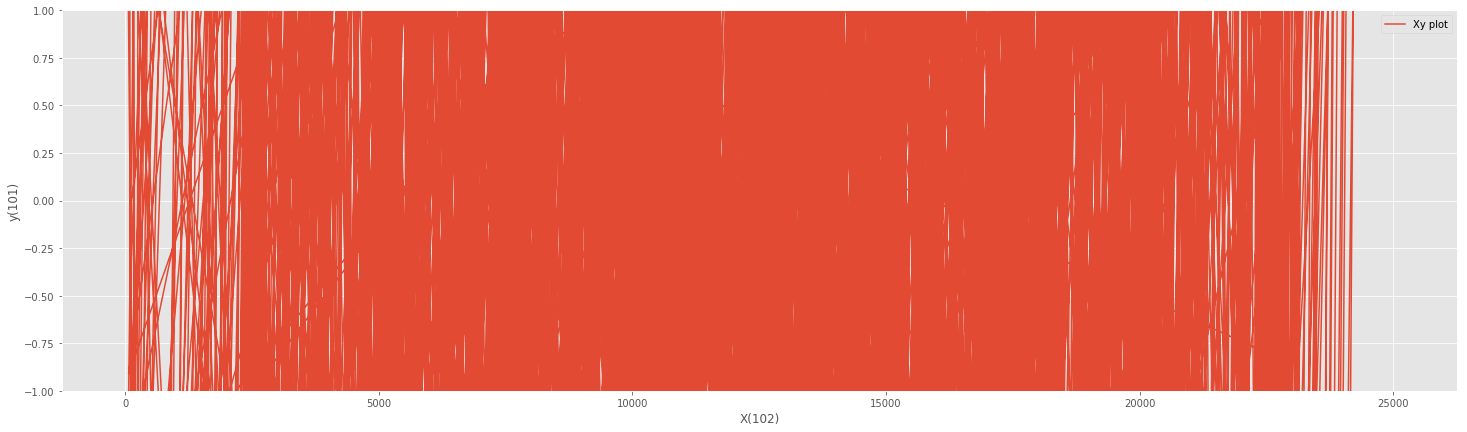

In [190]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (25,7)
plt.ylim(ymax=1, ymin=-1)
plt_x = range(len(data_X[:, 0]))
plt.plot(df['idx'][0:max_row].values, (training_y - y_predict), label='Xy plot')
plt.xlabel('X(102)')
plt.ylabel('y(101)')
plt.legend()
plt.show()

In [37]:
data_X

array([[2.448898, 2.465567, 2.550633],
       [2.448898, 2.46589 , 2.549986],
       [2.448898, 2.46589 , 2.549016],
       ...,
       [2.742026, 2.764193, 2.244701],
       [2.741379, 2.764516, 2.245024],
       [2.740732, 2.76387 , 2.245024]])

In [50]:
t = (data_X - np.average(data_X)) / (np.max(np.abs(data_X)) - np.average(data_X))

In [54]:
data_X[:,0]

(7000,)

In [61]:
type(data_X)

numpy.ndarray

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [157]:
scaler = MinMaxScaler(feature_range=(-1 + 1e-5, 1 - 1e-5))
scaler.fit(data_X)
data_X_arcsin = np.arcsin(scaler.transform(data_X))
data_X_sin = np.sin(scaler.transform(data_X))
data_X_arccos = np.arccos(scaler.transform(data_X))
data_X_cos = np.cos(scaler.transform(data_X))
training_X = np.concatenate((data_X_arcsin, data_X_sin, data_X_arccos, data_X_cos), axis=1)

In [158]:
training_X[0:5,:]

array([[-0.1278336 , -0.13933708,  0.16275196, -0.12714067, -0.13844057,
         0.1613263 ,  1.69862993,  1.71013341,  1.40804437,  0.9918847 ,
         0.99037074,  0.98690112],
       [-0.1278336 , -0.13843285,  0.16087501, -0.12714067, -0.13755362,
         0.15949786,  1.69862993,  1.70922918,  1.40992131,  0.9918847 ,
         0.99049432,  0.98719827],
       [-0.1278336 , -0.13843285,  0.15806211, -0.12714067, -0.13755362,
         0.15675559,  1.69862993,  1.70922918,  1.41273421,  0.9918847 ,
         0.99049432,  0.98763743],
       [-0.1278336 , -0.13662473,  0.1543145 , -0.12714067, -0.13577937,
         0.1530983 ,  1.69862993,  1.70742106,  1.41648183,  0.9918847 ,
         0.9907391 ,  0.98821096],
       [-0.12692077, -0.13300703,  0.15618658, -0.12624253, -0.13222684,
         0.1549258 ,  1.6977171 ,  1.70380336,  1.41460975,  0.99199941,
         0.99121948,  0.98792611]])

In [160]:
training_X[0:5,:]

array([[ 0.3739296 ,  0.38390939, -0.40243916,  0.35720738,  0.36585203,
        -0.38172675,  1.19686673,  1.18688693,  1.97323549,  0.9340251 ,
         0.93067303,  0.92427522],
       [-0.89656258, -0.90259836,  0.92419898, -0.70412175, -0.70678233,
         0.71605788,  2.46735891,  2.47339469,  0.64659734,  0.71007926,
         0.70743108,  0.69804091],
       [ 1.14443829,  1.15296175, -1.16429288,  0.78979699,  0.79193394,
        -0.79469744,  0.42635803,  0.41783458,  2.73508921,  0.61336834,
         0.61060677,  0.60700575],
       [-0.20856068, -0.2112422 ,  0.22599083, -0.20557575, -0.20814169,
         0.22220176,  1.77935701,  1.78203853,  1.3448055 ,  0.97864121,
         0.97809869,  0.97500071],
       [-1.13793026, -1.14205415,  1.15963314, -0.78813143, -0.78919025,
         0.79357164,  2.70872659,  2.71285047,  0.41116319,  0.61550699,
         0.61414881,  0.60847682]])

In [159]:
np.random.shuffle(training_X)

In [129]:
1e-5

1e-05